Ehsan Merrikhi - 400101967

In this Homework we will use CIFAR-10 dataset.

In [29]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import random_split, DataLoader
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from tqdm import tqdm 
from sklearn.metrics import confusion_matrix, accuracy_score
import numpy as np
import seaborn as sns

**Part 1.**

Download CIFAR-10 dataset and split train, validation and test data.

In [2]:
# Define transforms for the data
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize images
])

# Step 1: Download and load the CIFAR-10 dataset
train_dataset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform
)

test_dataset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform
)

# Step 2: Split 10,000 images from the training dataset for validation
train_size = len(train_dataset) - 10000  # 40,000 for training
val_size = 10000  # 10,000 for validation

train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

# Summarize the dataset
print(f"Training set size: {len(train_dataset)}")
print(f"Validation set size: {len(val_dataset)}")
print(f"Test set size: {len(test_dataset)}")

100%|██████████| 170498071/170498071 [00:03<00:00, 47562911.53it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Training set size: 40000
Validation set size: 10000
Test set size: 10000


Showing sample images from each class.

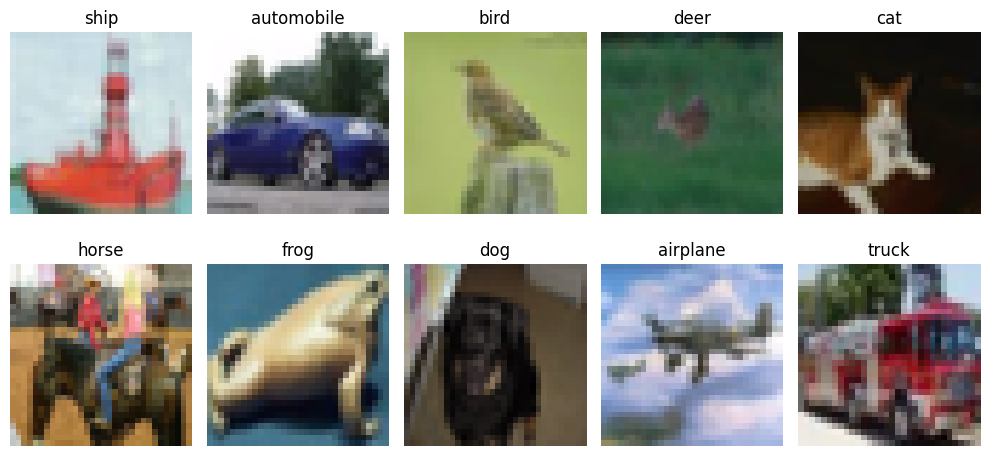

In [3]:
# Step 3: Display one image from each class
class_names = train_dataset.dataset.classes  # Get CIFAR-10 class names
sample_images = {}

# Find one image for each class
for image, label in train_dataset:
    class_name = class_names[label]
    if class_name not in sample_images:
        sample_images[class_name] = image
    if len(sample_images) == len(class_names):
        break

# Plot the sample images
fig, axes = plt.subplots(2, 5, figsize=(10, 5))
axes = axes.flatten()

for ax, (class_name, image) in zip(axes, sample_images.items()):
    # Convert tensor to numpy and unnormalize for display
    img = image.permute(1, 2, 0).numpy() * 0.5 + 0.5  # Reverse normalization
    ax.imshow(img)
    ax.set_title(class_name)
    ax.axis('off')

plt.tight_layout()
plt.show()

**Part 2.**

In [4]:
# Define the Baseline Model
class BaselineModel(nn.Module):
    def __init__(self):
        super(BaselineModel, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=5)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(32 * 14 * 14, 10)  # Output size = 10 (for CIFAR-10 classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.flatten(x)
        x = self.fc(x)
        return x

# Initialize model, criterion, and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
baseline_model = BaselineModel().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(baseline_model.parameters(), lr=0.01)


Create dataloaders.

In [5]:
# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

Train model and save the best model.

In [6]:
# Training function with tqdm
def train_model(model, criterion, optimizer, train_loader, val_loader, device, best_model_name, num_epochs=10):
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []
    best_val_accuracy = 0.0
    best_model_state = None

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        correct_train = 0
        total_train = 0

        # Add tqdm for the training progress
        train_progress = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training")
        for images, labels in train_progress:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct_train += (predicted == labels).sum().item()
            total_train += labels.size(0)

            # Update tqdm progress bar with loss
            train_progress.set_postfix({"Loss": loss.item()})

        train_accuracy = correct_train / total_train
        train_losses.append(train_loss / len(train_loader))
        train_accuracies.append(train_accuracy)

        # Validation phase
        model.eval()
        val_loss = 0.0
        correct_val = 0
        total_val = 0

        # Add tqdm for the validation progress
        val_progress = tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Validation", leave=False)
        with torch.no_grad():
            for images, labels in val_progress:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                correct_val += (predicted == labels).sum().item()
                total_val += labels.size(0)

                # Update tqdm progress bar with loss
                val_progress.set_postfix({"Loss": loss.item()})

        val_accuracy = correct_val / total_val
        val_losses.append(val_loss / len(val_loader))
        val_accuracies.append(val_accuracy)

        # Save the best model
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            best_model_state = model.state_dict()

        print(f"Epoch {epoch+1}/{num_epochs}:")
        print(f"  Train Loss: {train_losses[-1]:.4f}, Train Accuracy: {train_accuracies[-1]:.4f}")
        print(f"  Val Loss: {val_losses[-1]:.4f}, Val Accuracy: {val_accuracies[-1]:.4f}")

    # Save the best model
    torch.save(best_model_state, best_model_name+".pth")
    print("Best model saved with validation accuracy:", best_val_accuracy)

    return train_losses, val_losses, train_accuracies, val_accuracies

# Train the baseline model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
num_epochs = 20
train_losses, val_losses, train_accuracies, val_accuracies = train_model(
    baseline_model, criterion, optimizer, train_loader, val_loader, device, "best_baseline_model", num_epochs
)


Epoch 1/20 - Training: 100%|██████████| 1250/1250 [00:09<00:00, 132.99it/s, Loss=1.33]


Epoch 1/20:
  Train Loss: 1.6353, Train Accuracy: 0.4296
  Val Loss: 1.4203, Val Accuracy: 0.5027


Epoch 2/20 - Training: 100%|██████████| 1250/1250 [00:08<00:00, 145.33it/s, Loss=1.38] 


Epoch 2/20:
  Train Loss: 1.3394, Train Accuracy: 0.5316
  Val Loss: 1.3332, Val Accuracy: 0.5331


Epoch 3/20 - Training: 100%|██████████| 1250/1250 [00:08<00:00, 147.21it/s, Loss=1.37] 


Epoch 3/20:
  Train Loss: 1.2444, Train Accuracy: 0.5664
  Val Loss: 1.2368, Val Accuracy: 0.5699


Epoch 4/20 - Training: 100%|██████████| 1250/1250 [00:08<00:00, 144.43it/s, Loss=1.07] 


Epoch 4/20:
  Train Loss: 1.1704, Train Accuracy: 0.5946
  Val Loss: 1.1824, Val Accuracy: 0.5936


Epoch 5/20 - Training: 100%|██████████| 1250/1250 [00:08<00:00, 147.39it/s, Loss=0.898]


Epoch 5/20:
  Train Loss: 1.1039, Train Accuracy: 0.6179
  Val Loss: 1.1524, Val Accuracy: 0.5990


Epoch 6/20 - Training: 100%|██████████| 1250/1250 [00:08<00:00, 147.71it/s, Loss=1.14] 


Epoch 6/20:
  Train Loss: 1.0537, Train Accuracy: 0.6351
  Val Loss: 1.1147, Val Accuracy: 0.6167


Epoch 7/20 - Training: 100%|██████████| 1250/1250 [00:08<00:00, 143.54it/s, Loss=1.32] 


Epoch 7/20:
  Train Loss: 1.0110, Train Accuracy: 0.6522
  Val Loss: 1.1382, Val Accuracy: 0.6076


Epoch 8/20 - Training: 100%|██████████| 1250/1250 [00:08<00:00, 145.88it/s, Loss=0.884]


Epoch 8/20:
  Train Loss: 0.9796, Train Accuracy: 0.6638
  Val Loss: 1.0774, Val Accuracy: 0.6293


Epoch 9/20 - Training: 100%|██████████| 1250/1250 [00:08<00:00, 145.86it/s, Loss=0.613]


Epoch 9/20:
  Train Loss: 0.9492, Train Accuracy: 0.6748
  Val Loss: 1.0601, Val Accuracy: 0.6383


Epoch 10/20 - Training: 100%|██████████| 1250/1250 [00:08<00:00, 140.86it/s, Loss=1.16] 


Epoch 10/20:
  Train Loss: 0.9281, Train Accuracy: 0.6791
  Val Loss: 1.0482, Val Accuracy: 0.6412


Epoch 11/20 - Training: 100%|██████████| 1250/1250 [00:08<00:00, 146.63it/s, Loss=1.12] 


Epoch 11/20:
  Train Loss: 0.9040, Train Accuracy: 0.6897
  Val Loss: 1.0700, Val Accuracy: 0.6328


Epoch 12/20 - Training: 100%|██████████| 1250/1250 [00:08<00:00, 145.56it/s, Loss=0.882]


Epoch 12/20:
  Train Loss: 0.8873, Train Accuracy: 0.6952
  Val Loss: 1.0703, Val Accuracy: 0.6310


Epoch 13/20 - Training: 100%|██████████| 1250/1250 [00:08<00:00, 145.96it/s, Loss=0.919]


Epoch 13/20:
  Train Loss: 0.8671, Train Accuracy: 0.7035
  Val Loss: 1.0469, Val Accuracy: 0.6455


Epoch 14/20 - Training: 100%|██████████| 1250/1250 [00:08<00:00, 149.41it/s, Loss=0.823]


Epoch 14/20:
  Train Loss: 0.8524, Train Accuracy: 0.7063
  Val Loss: 1.0471, Val Accuracy: 0.6404


Epoch 15/20 - Training: 100%|██████████| 1250/1250 [00:08<00:00, 149.12it/s, Loss=0.71] 


Epoch 15/20:
  Train Loss: 0.8331, Train Accuracy: 0.7134
  Val Loss: 1.0492, Val Accuracy: 0.6453


Epoch 16/20 - Training: 100%|██████████| 1250/1250 [00:08<00:00, 146.62it/s, Loss=0.997]


Epoch 16/20:
  Train Loss: 0.8207, Train Accuracy: 0.7174
  Val Loss: 1.0489, Val Accuracy: 0.6493


Epoch 17/20 - Training: 100%|██████████| 1250/1250 [00:08<00:00, 147.88it/s, Loss=0.91] 


Epoch 17/20:
  Train Loss: 0.8059, Train Accuracy: 0.7228
  Val Loss: 1.0379, Val Accuracy: 0.6480


Epoch 18/20 - Training: 100%|██████████| 1250/1250 [00:08<00:00, 148.94it/s, Loss=0.508]


Epoch 18/20:
  Train Loss: 0.7922, Train Accuracy: 0.7274
  Val Loss: 1.0830, Val Accuracy: 0.6377


Epoch 19/20 - Training: 100%|██████████| 1250/1250 [00:08<00:00, 143.69it/s, Loss=0.887]


Epoch 19/20:
  Train Loss: 0.7795, Train Accuracy: 0.7337
  Val Loss: 1.0400, Val Accuracy: 0.6522


Epoch 20/20 - Training: 100%|██████████| 1250/1250 [00:08<00:00, 147.77it/s, Loss=0.58] 


Epoch 20/20:
  Train Loss: 0.7684, Train Accuracy: 0.7370
  Val Loss: 1.0517, Val Accuracy: 0.6473
Best model saved with validation accuracy: 0.6522


Plotting loss and accuracy plots while training the model.

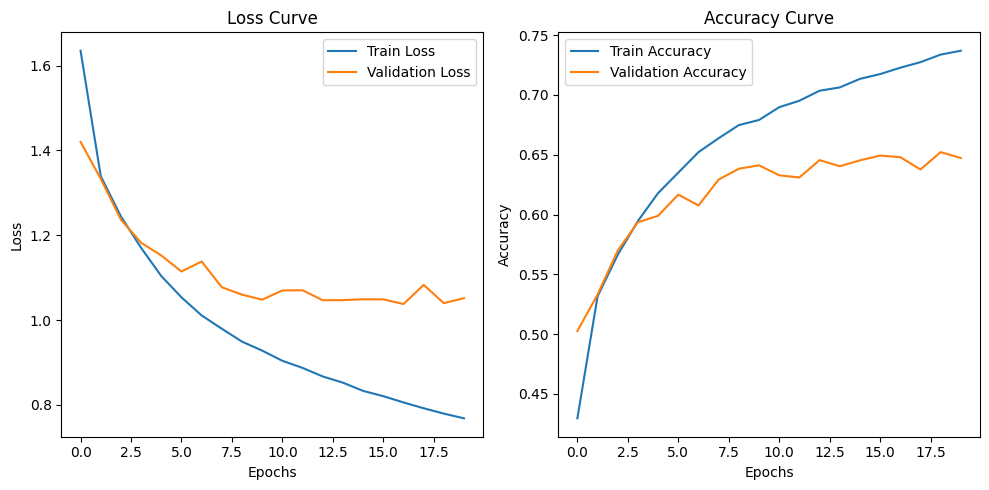

In [8]:
# Plot accuracy and loss figures
plt.figure(figsize=(10, 5))

# Plot losses
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss Curve")
plt.legend()

# Plot accuracies
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label="Train Accuracy")
plt.plot(val_accuracies, label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy Curve")
plt.legend()

plt.tight_layout()
plt.show()

**Part 3.**

Upgrade the Baseline Model.

Train again and report the results.

In [11]:
class ImprovedModel(nn.Module):
    def __init__(self):
        super(ImprovedModel, self).__init__()
        
        # Convolutional layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        
        # Activation and pooling
        self.leaky_relu = nn.LeakyReLU(negative_slope=0.01)  # Replacing ReLU with Leaky ReLU
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Fully connected layers
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(256 * 2 * 2, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 10)

    def forward(self, x):
        # Convolutional layers with pooling
        x = self.conv1(x)
        x = self.leaky_relu(x)
        x = self.maxpool(x)

        x = self.conv2(x)
        x = self.leaky_relu(x)
        x = self.maxpool(x)

        x = self.conv3(x)
        x = self.leaky_relu(x)
        x = self.maxpool(x)

        x = self.conv4(x)
        x = self.leaky_relu(x)
        x = self.maxpool(x)

        # Fully connected layers
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.leaky_relu(x)
        x = self.fc2(x)
        x = self.leaky_relu(x)
        x = self.fc3(x)
        return x

# Initialize model, criterion, and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
improved_model = ImprovedModel().to(device)
criterion = nn.CrossEntropyLoss()  # Still using CrossEntropyLoss
optimizer = optim.SGD(improved_model.parameters(), lr=0.01)

Train Improved Model.

In [12]:
# Train the baseline model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
num_epochs = 20
train_losses_improved, val_losses_improved, train_accuracies_improved, val_accuracies_improved = train_model(
    improved_model, criterion, optimizer, train_loader, val_loader, device, "best_improved_model", num_epochs
)


Epoch 1/20 - Training: 100%|██████████| 1250/1250 [00:09<00:00, 136.57it/s, Loss=2.3] 


Epoch 1/20:
  Train Loss: 2.3016, Train Accuracy: 0.1053
  Val Loss: 2.2998, Val Accuracy: 0.1378


Epoch 2/20 - Training: 100%|██████████| 1250/1250 [00:09<00:00, 134.22it/s, Loss=2.22]


Epoch 2/20:
  Train Loss: 2.2821, Train Accuracy: 0.1884
  Val Loss: 2.1901, Val Accuracy: 0.1983


Epoch 3/20 - Training: 100%|██████████| 1250/1250 [00:08<00:00, 140.59it/s, Loss=1.69]


Epoch 3/20:
  Train Loss: 1.9995, Train Accuracy: 0.2543
  Val Loss: 1.8615, Val Accuracy: 0.2981


Epoch 4/20 - Training: 100%|██████████| 1250/1250 [00:09<00:00, 130.16it/s, Loss=1.62]


Epoch 4/20:
  Train Loss: 1.7462, Train Accuracy: 0.3493
  Val Loss: 1.6013, Val Accuracy: 0.4027


Epoch 5/20 - Training: 100%|██████████| 1250/1250 [00:09<00:00, 129.42it/s, Loss=1.24]


Epoch 5/20:
  Train Loss: 1.5737, Train Accuracy: 0.4170
  Val Loss: 1.4717, Val Accuracy: 0.4572


Epoch 6/20 - Training: 100%|██████████| 1250/1250 [00:09<00:00, 132.66it/s, Loss=1.68] 


Epoch 6/20:
  Train Loss: 1.4597, Train Accuracy: 0.4646
  Val Loss: 1.3984, Val Accuracy: 0.4878


Epoch 7/20 - Training: 100%|██████████| 1250/1250 [00:09<00:00, 138.39it/s, Loss=1.27] 


Epoch 7/20:
  Train Loss: 1.3644, Train Accuracy: 0.5050
  Val Loss: 1.3525, Val Accuracy: 0.5061


Epoch 8/20 - Training: 100%|██████████| 1250/1250 [00:09<00:00, 138.59it/s, Loss=1.27] 


Epoch 8/20:
  Train Loss: 1.2763, Train Accuracy: 0.5404
  Val Loss: 1.2373, Val Accuracy: 0.5500


Epoch 9/20 - Training: 100%|██████████| 1250/1250 [00:08<00:00, 140.71it/s, Loss=1.03] 


Epoch 9/20:
  Train Loss: 1.1978, Train Accuracy: 0.5710
  Val Loss: 1.1989, Val Accuracy: 0.5695


Epoch 10/20 - Training: 100%|██████████| 1250/1250 [00:09<00:00, 136.25it/s, Loss=1.41] 


Epoch 10/20:
  Train Loss: 1.1130, Train Accuracy: 0.6018
  Val Loss: 1.1426, Val Accuracy: 0.5930


Epoch 11/20 - Training: 100%|██████████| 1250/1250 [00:09<00:00, 138.58it/s, Loss=1.19] 


Epoch 11/20:
  Train Loss: 1.0354, Train Accuracy: 0.6330
  Val Loss: 1.1236, Val Accuracy: 0.6019


Epoch 12/20 - Training: 100%|██████████| 1250/1250 [00:08<00:00, 140.83it/s, Loss=0.668]


Epoch 12/20:
  Train Loss: 0.9637, Train Accuracy: 0.6592
  Val Loss: 1.0370, Val Accuracy: 0.6358


Epoch 13/20 - Training: 100%|██████████| 1250/1250 [00:09<00:00, 135.25it/s, Loss=0.649]


Epoch 13/20:
  Train Loss: 0.8945, Train Accuracy: 0.6825
  Val Loss: 0.9980, Val Accuracy: 0.6459


Epoch 14/20 - Training: 100%|██████████| 1250/1250 [00:09<00:00, 136.91it/s, Loss=0.819]


Epoch 14/20:
  Train Loss: 0.8343, Train Accuracy: 0.7048
  Val Loss: 0.9307, Val Accuracy: 0.6749


Epoch 15/20 - Training: 100%|██████████| 1250/1250 [00:09<00:00, 137.95it/s, Loss=0.473]


Epoch 15/20:
  Train Loss: 0.7719, Train Accuracy: 0.7299
  Val Loss: 0.8724, Val Accuracy: 0.6950


Epoch 16/20 - Training: 100%|██████████| 1250/1250 [00:09<00:00, 135.82it/s, Loss=0.918]


Epoch 16/20:
  Train Loss: 0.7120, Train Accuracy: 0.7492
  Val Loss: 0.8454, Val Accuracy: 0.7020


Epoch 17/20 - Training: 100%|██████████| 1250/1250 [00:08<00:00, 140.66it/s, Loss=0.71] 


Epoch 17/20:
  Train Loss: 0.6545, Train Accuracy: 0.7697
  Val Loss: 0.9688, Val Accuracy: 0.6758


Epoch 18/20 - Training: 100%|██████████| 1250/1250 [00:09<00:00, 138.46it/s, Loss=0.745]


Epoch 18/20:
  Train Loss: 0.6000, Train Accuracy: 0.7891
  Val Loss: 0.8789, Val Accuracy: 0.7044


Epoch 19/20 - Training: 100%|██████████| 1250/1250 [00:09<00:00, 135.65it/s, Loss=0.326]


Epoch 19/20:
  Train Loss: 0.5413, Train Accuracy: 0.8131
  Val Loss: 0.8571, Val Accuracy: 0.7166


Epoch 20/20 - Training: 100%|██████████| 1250/1250 [00:09<00:00, 136.85it/s, Loss=0.159]


Epoch 20/20:
  Train Loss: 0.4887, Train Accuracy: 0.8294
  Val Loss: 0.8654, Val Accuracy: 0.7079
Best model saved with validation accuracy: 0.7166


Visualization

*We see the model starts to overfit in the process of training*

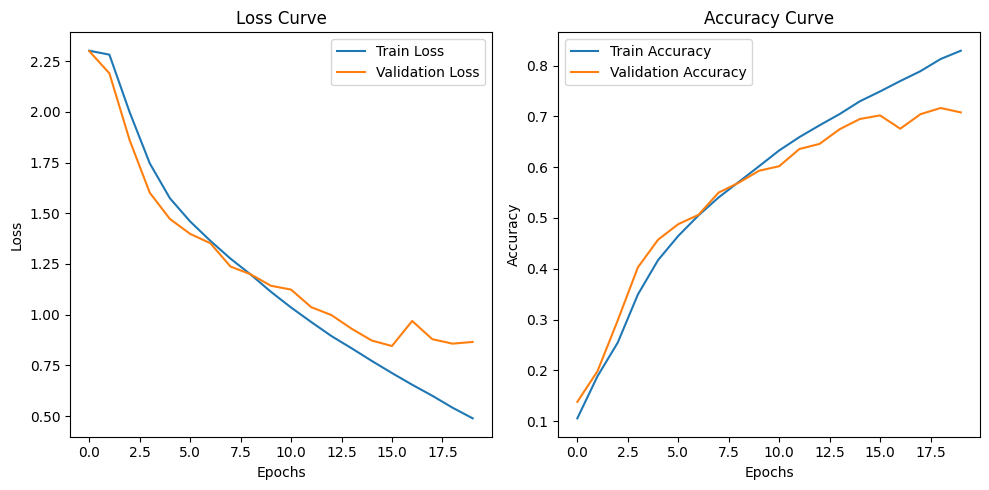

In [13]:
# Plot accuracy and loss figures
plt.figure(figsize=(10, 5))

# Plot losses
plt.subplot(1, 2, 1)
plt.plot(train_losses_improved, label="Train Loss")
plt.plot(val_losses_improved, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss Curve")
plt.legend()

# Plot accuracies
plt.subplot(1, 2, 2)
plt.plot(train_accuracies_improved, label="Train Accuracy")
plt.plot(val_accuracies_improved, label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy Curve")
plt.legend()

plt.tight_layout()
plt.show()

**Part 4.**

Add batch normalization layers to the improved network

In [36]:
class ImprovedModelWithBN(nn.Module):
    def __init__(self):
        super(ImprovedModelWithBN, self).__init__()
        
        # Convolutional layers with batch normalization
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        
        # Activation and pooling
        self.leaky_relu = nn.LeakyReLU(negative_slope=0.01) 
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Fully connected layers
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(256 * 2 * 2, 512)
        
        self.fc2 = nn.Linear(512, 256)
        
        self.fc3 = nn.Linear(256, 10)

    def forward(self, x):
        # Convolutional layers with pooling and batch normalization
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.leaky_relu(x)
        x = self.maxpool(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.leaky_relu(x)
        x = self.maxpool(x)

        x = self.conv3(x)
        x = self.bn3(x)
        x = self.leaky_relu(x)
        x = self.maxpool(x)

        x = self.conv4(x)
        x = self.bn4(x)
        x = self.leaky_relu(x)
        x = self.maxpool(x)

        # Fully connected layers 
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.leaky_relu(x)
        x = self.fc2(x)
        x = self.leaky_relu(x)
        x = self.fc3(x)
        return x

# Initialize model, criterion, and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
improved_model_with_bn = ImprovedModelWithBN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(improved_model.parameters(), lr=0.01)


Train the model with batch normalization layers added

In [37]:
# Train the baseline model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
num_epochs = 20
train_losses_improved_with_bn, val_losses_improved_with_bn, train_accuracies_improved_with_bn, val_accuracies_improved_with_bn = train_model(
    improved_model_with_bn, criterion, optimizer, train_loader, val_loader, device, "best_improved_model_with_bn", num_epochs
)


Epoch 1/20 - Training: 100%|██████████| 1250/1250 [00:10<00:00, 122.32it/s, Loss=2.29]


Epoch 1/20:
  Train Loss: 2.3110, Train Accuracy: 0.1055
  Val Loss: 2.3101, Val Accuracy: 0.1076


Epoch 2/20 - Training: 100%|██████████| 1250/1250 [00:10<00:00, 120.68it/s, Loss=2.31]


Epoch 2/20:
  Train Loss: 2.3110, Train Accuracy: 0.1038
  Val Loss: 2.3102, Val Accuracy: 0.1073


Epoch 3/20 - Training: 100%|██████████| 1250/1250 [00:10<00:00, 121.61it/s, Loss=2.31]


Epoch 3/20:
  Train Loss: 2.3110, Train Accuracy: 0.1038
  Val Loss: 2.3100, Val Accuracy: 0.1080


Epoch 4/20 - Training: 100%|██████████| 1250/1250 [00:10<00:00, 119.35it/s, Loss=2.32]


Epoch 4/20:
  Train Loss: 2.3111, Train Accuracy: 0.1056
  Val Loss: 2.3104, Val Accuracy: 0.1067


Epoch 5/20 - Training: 100%|██████████| 1250/1250 [00:10<00:00, 121.95it/s, Loss=2.33]


Epoch 5/20:
  Train Loss: 2.3110, Train Accuracy: 0.1042
  Val Loss: 2.3104, Val Accuracy: 0.1066


Epoch 6/20 - Training: 100%|██████████| 1250/1250 [00:10<00:00, 121.11it/s, Loss=2.3] 


Epoch 6/20:
  Train Loss: 2.3110, Train Accuracy: 0.1053
  Val Loss: 2.3105, Val Accuracy: 0.1068


Epoch 7/20 - Training: 100%|██████████| 1250/1250 [00:10<00:00, 120.29it/s, Loss=2.27]


Epoch 7/20:
  Train Loss: 2.3109, Train Accuracy: 0.1045
  Val Loss: 2.3100, Val Accuracy: 0.1082


Epoch 8/20 - Training: 100%|██████████| 1250/1250 [00:10<00:00, 122.01it/s, Loss=2.33]


Epoch 8/20:
  Train Loss: 2.3111, Train Accuracy: 0.1045
  Val Loss: 2.3102, Val Accuracy: 0.1074


Epoch 9/20 - Training: 100%|██████████| 1250/1250 [00:10<00:00, 120.85it/s, Loss=2.32]


Epoch 9/20:
  Train Loss: 2.3109, Train Accuracy: 0.1057
  Val Loss: 2.3100, Val Accuracy: 0.1075


Epoch 10/20 - Training: 100%|██████████| 1250/1250 [00:10<00:00, 122.63it/s, Loss=2.32]


Epoch 10/20:
  Train Loss: 2.3110, Train Accuracy: 0.1050
  Val Loss: 2.3105, Val Accuracy: 0.1062


Epoch 11/20 - Training: 100%|██████████| 1250/1250 [00:10<00:00, 122.37it/s, Loss=2.33]


Epoch 11/20:
  Train Loss: 2.3110, Train Accuracy: 0.1038
  Val Loss: 2.3102, Val Accuracy: 0.1067


Epoch 12/20 - Training: 100%|██████████| 1250/1250 [00:10<00:00, 120.32it/s, Loss=2.3] 


Epoch 12/20:
  Train Loss: 2.3111, Train Accuracy: 0.1056
  Val Loss: 2.3100, Val Accuracy: 0.1076


Epoch 13/20 - Training: 100%|██████████| 1250/1250 [00:10<00:00, 123.37it/s, Loss=2.3] 


Epoch 13/20:
  Train Loss: 2.3111, Train Accuracy: 0.1053
  Val Loss: 2.3102, Val Accuracy: 0.1084


Epoch 14/20 - Training: 100%|██████████| 1250/1250 [00:10<00:00, 119.92it/s, Loss=2.29]


Epoch 14/20:
  Train Loss: 2.3110, Train Accuracy: 0.1049
  Val Loss: 2.3100, Val Accuracy: 0.1068


Epoch 15/20 - Training: 100%|██████████| 1250/1250 [00:10<00:00, 122.93it/s, Loss=2.32]


Epoch 15/20:
  Train Loss: 2.3111, Train Accuracy: 0.1048
  Val Loss: 2.3102, Val Accuracy: 0.1070


Epoch 16/20 - Training: 100%|██████████| 1250/1250 [00:10<00:00, 122.88it/s, Loss=2.28]


Epoch 16/20:
  Train Loss: 2.3110, Train Accuracy: 0.1051
  Val Loss: 2.3100, Val Accuracy: 0.1094


Epoch 17/20 - Training: 100%|██████████| 1250/1250 [00:10<00:00, 120.35it/s, Loss=2.29]


Epoch 17/20:
  Train Loss: 2.3110, Train Accuracy: 0.1050
  Val Loss: 2.3101, Val Accuracy: 0.1066


Epoch 18/20 - Training: 100%|██████████| 1250/1250 [00:10<00:00, 122.62it/s, Loss=2.3] 


Epoch 18/20:
  Train Loss: 2.3112, Train Accuracy: 0.1045
  Val Loss: 2.3100, Val Accuracy: 0.1088


Epoch 19/20 - Training: 100%|██████████| 1250/1250 [00:10<00:00, 121.74it/s, Loss=2.29]


Epoch 19/20:
  Train Loss: 2.3111, Train Accuracy: 0.1046
  Val Loss: 2.3101, Val Accuracy: 0.1080


Epoch 20/20 - Training: 100%|██████████| 1250/1250 [00:10<00:00, 116.47it/s, Loss=2.34]


Epoch 20/20:
  Train Loss: 2.3110, Train Accuracy: 0.1054
  Val Loss: 2.3103, Val Accuracy: 0.1068
Best model saved with validation accuracy: 0.1094


plots and reports

In [ ]:
# Plot accuracy and loss figures
plt.figure(figsize=(10, 5))

# Plot losses
plt.subplot(1, 2, 1)
plt.plot(train_losses_improved_with_bn, label="Train Loss")
plt.plot(val_losses_improved_with_bn, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss Curve")
plt.legend()

# Plot accuracies
plt.subplot(1, 2, 2)
plt.plot(train_accuracies_improved_with_bn, label="Train Accuracy")
plt.plot(val_accuracies_improved_with_bn, label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy Curve")
plt.legend()

plt.tight_layout()
plt.show()

**Part 5.**

In [23]:
class ImprovedModelWithBNAndDO(nn.Module):
    def __init__(self):
        super(ImprovedModelWithBNAndDO, self).__init__()
        
        # Convolutional layers with batch normalization
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        
        # Activation and pooling
        self.leaky_relu = nn.LeakyReLU(negative_slope=0.01) 
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Fully connected layers with dropout
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(256 * 2 * 2, 512)
        self.dropout1 = nn.Dropout(p=0.5)  # Dropout with 50% probability
        
        self.fc2 = nn.Linear(512, 256)
        self.dropout2 = nn.Dropout(p=0.5)  # Dropout with 50% probability
        
        self.fc3 = nn.Linear(256, 10)

    def forward(self, x):
        # Convolutional layers with pooling and batch normalization
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.leaky_relu(x)
        x = self.maxpool(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.leaky_relu(x)
        x = self.maxpool(x)

        x = self.conv3(x)
        x = self.bn3(x)
        x = self.leaky_relu(x)
        x = self.maxpool(x)

        x = self.conv4(x)
        x = self.bn4(x)
        x = self.leaky_relu(x)
        x = self.maxpool(x)

        # Fully connected layers with dropout
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.dropout1(x)  # Apply dropout after first FC layer
        x = self.leaky_relu(x)
        x = self.fc2(x)
        x = self.dropout2(x)  # Apply dropout after second FC layer
        x = self.leaky_relu(x)
        x = self.fc3(x)
        return x

# Initialize model, criterion, and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
improved_model_with_bn_and_do = ImprovedModelWithBNAndDO().to(device)
criterion = nn.CrossEntropyLoss()  # Still using CrossEntropyLoss
optimizer = optim.SGD(improved_model_with_bn_and_do.parameters(), lr=0.01)


Train the model with dropouts added to FC layers

In [24]:
# Train the baseline model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
num_epochs = 20
train_losses_improved_with_bn_and_do, val_losses_improved_with_bn_and_do, train_accuracies_improved_with_bn_and_do, val_accuracies_improved_with_bn_and_do = train_model(
    improved_model_with_bn_and_do, criterion, optimizer, train_loader, val_loader, device, "best_improved_model_with_bn_and_do", num_epochs
)


Epoch 1/20 - Training: 100%|██████████| 1250/1250 [00:10<00:00, 119.34it/s, Loss=1.25]


Epoch 1/20:
  Train Loss: 1.6677, Train Accuracy: 0.3760
  Val Loss: 1.2607, Val Accuracy: 0.5449


Epoch 2/20 - Training: 100%|██████████| 1250/1250 [00:10<00:00, 120.98it/s, Loss=1.23] 


Epoch 2/20:
  Train Loss: 1.2311, Train Accuracy: 0.5560
  Val Loss: 1.0316, Val Accuracy: 0.6252


Epoch 3/20 - Training: 100%|██████████| 1250/1250 [00:10<00:00, 121.11it/s, Loss=1.08] 


Epoch 3/20:
  Train Loss: 1.0456, Train Accuracy: 0.6276
  Val Loss: 0.9332, Val Accuracy: 0.6654


Epoch 4/20 - Training: 100%|██████████| 1250/1250 [00:10<00:00, 121.86it/s, Loss=0.594]


Epoch 4/20:
  Train Loss: 0.9183, Train Accuracy: 0.6757
  Val Loss: 0.8763, Val Accuracy: 0.6926


Epoch 5/20 - Training: 100%|██████████| 1250/1250 [00:10<00:00, 118.12it/s, Loss=0.432]


Epoch 5/20:
  Train Loss: 0.8221, Train Accuracy: 0.7127
  Val Loss: 0.8244, Val Accuracy: 0.7077


Epoch 6/20 - Training: 100%|██████████| 1250/1250 [00:10<00:00, 121.85it/s, Loss=0.988]


Epoch 6/20:
  Train Loss: 0.7510, Train Accuracy: 0.7359
  Val Loss: 0.7619, Val Accuracy: 0.7358


Epoch 7/20 - Training: 100%|██████████| 1250/1250 [00:10<00:00, 121.05it/s, Loss=0.62] 


Epoch 7/20:
  Train Loss: 0.6776, Train Accuracy: 0.7669
  Val Loss: 0.7512, Val Accuracy: 0.7427


Epoch 8/20 - Training: 100%|██████████| 1250/1250 [00:10<00:00, 120.29it/s, Loss=0.536]


Epoch 8/20:
  Train Loss: 0.6116, Train Accuracy: 0.7886
  Val Loss: 0.7561, Val Accuracy: 0.7439


Epoch 9/20 - Training: 100%|██████████| 1250/1250 [00:10<00:00, 122.21it/s, Loss=0.412]


Epoch 9/20:
  Train Loss: 0.5568, Train Accuracy: 0.8067
  Val Loss: 0.7483, Val Accuracy: 0.7403


Epoch 10/20 - Training: 100%|██████████| 1250/1250 [00:10<00:00, 118.86it/s, Loss=0.619]


Epoch 10/20:
  Train Loss: 0.5064, Train Accuracy: 0.8249
  Val Loss: 0.7621, Val Accuracy: 0.7455


Epoch 11/20 - Training: 100%|██████████| 1250/1250 [00:10<00:00, 121.10it/s, Loss=0.726]


Epoch 11/20:
  Train Loss: 0.4620, Train Accuracy: 0.8398
  Val Loss: 0.8641, Val Accuracy: 0.7337


Epoch 12/20 - Training: 100%|██████████| 1250/1250 [00:10<00:00, 121.99it/s, Loss=0.671]


Epoch 12/20:
  Train Loss: 0.4097, Train Accuracy: 0.8584
  Val Loss: 0.7416, Val Accuracy: 0.7591


Epoch 13/20 - Training: 100%|██████████| 1250/1250 [00:10<00:00, 119.46it/s, Loss=0.677]


Epoch 13/20:
  Train Loss: 0.3800, Train Accuracy: 0.8681
  Val Loss: 0.7749, Val Accuracy: 0.7541


Epoch 14/20 - Training: 100%|██████████| 1250/1250 [00:10<00:00, 121.57it/s, Loss=0.16] 


Epoch 14/20:
  Train Loss: 0.3390, Train Accuracy: 0.8819
  Val Loss: 0.7355, Val Accuracy: 0.7712


Epoch 15/20 - Training: 100%|██████████| 1250/1250 [00:10<00:00, 118.84it/s, Loss=0.272] 


Epoch 15/20:
  Train Loss: 0.3050, Train Accuracy: 0.8955
  Val Loss: 0.7628, Val Accuracy: 0.7659


Epoch 16/20 - Training: 100%|██████████| 1250/1250 [00:10<00:00, 121.48it/s, Loss=0.191] 


Epoch 16/20:
  Train Loss: 0.2745, Train Accuracy: 0.9068
  Val Loss: 0.8423, Val Accuracy: 0.7567


Epoch 17/20 - Training: 100%|██████████| 1250/1250 [00:10<00:00, 119.31it/s, Loss=0.287] 


Epoch 17/20:
  Train Loss: 0.2511, Train Accuracy: 0.9131
  Val Loss: 0.8096, Val Accuracy: 0.7695


Epoch 18/20 - Training: 100%|██████████| 1250/1250 [00:10<00:00, 117.53it/s, Loss=0.0965]


Epoch 18/20:
  Train Loss: 0.2222, Train Accuracy: 0.9231
  Val Loss: 0.8475, Val Accuracy: 0.7707


Epoch 19/20 - Training: 100%|██████████| 1250/1250 [00:10<00:00, 121.52it/s, Loss=0.219] 


Epoch 19/20:
  Train Loss: 0.1984, Train Accuracy: 0.9316
  Val Loss: 0.8029, Val Accuracy: 0.7693


Epoch 20/20 - Training: 100%|██████████| 1250/1250 [00:10<00:00, 119.74it/s, Loss=0.175] 


Epoch 20/20:
  Train Loss: 0.1785, Train Accuracy: 0.9386
  Val Loss: 0.8526, Val Accuracy: 0.7765
Best model saved with validation accuracy: 0.7765


Plots and Reports

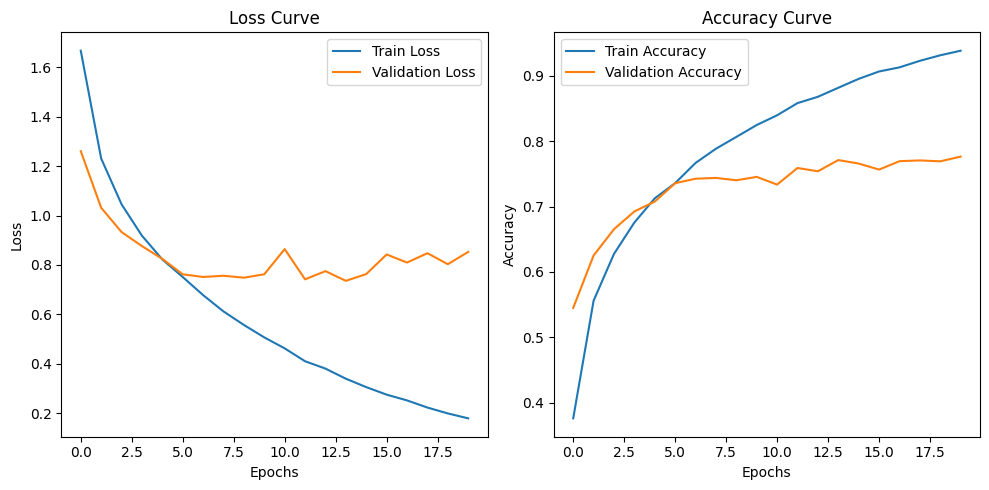

In [25]:
# Plot accuracy and loss figures
plt.figure(figsize=(10, 5))

# Plot losses
plt.subplot(1, 2, 1)
plt.plot(train_losses_improved_with_bn_and_do, label="Train Loss")
plt.plot(val_losses_improved_with_bn_and_do, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss Curve")
plt.legend()

# Plot accuracies
plt.subplot(1, 2, 2)
plt.plot(train_accuracies_improved_with_bn_and_do, label="Train Accuracy")
plt.plot(val_accuracies_improved_with_bn_and_do, label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy Curve")
plt.legend()

plt.tight_layout()
plt.show()

**Part 6.**

/tmp/ipykernel_23/2944194260.py:41: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(path)


Accuracy for Section B: 64.70%


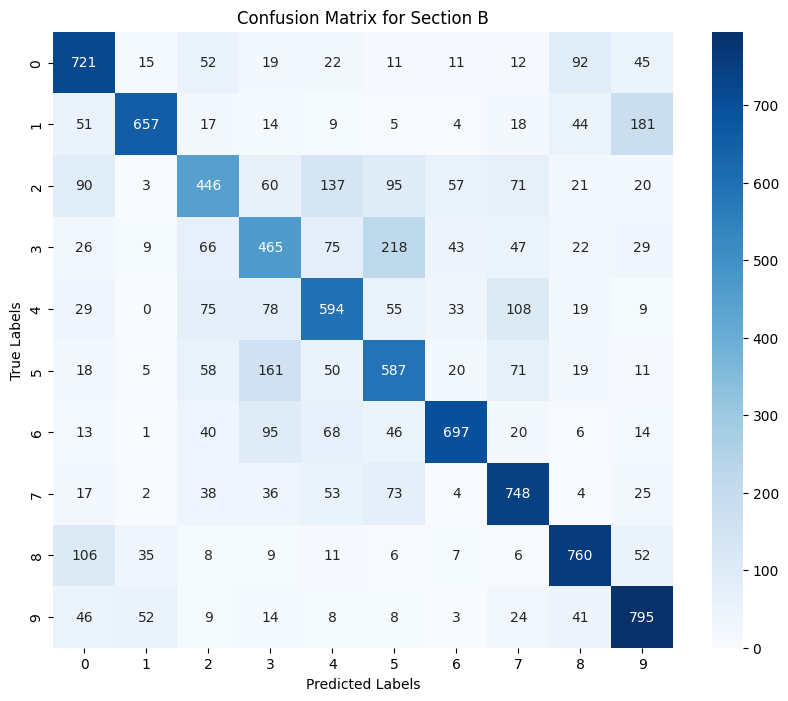

/tmp/ipykernel_23/2944194260.py:41: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(path)


Accuracy for Section C: 71.39%


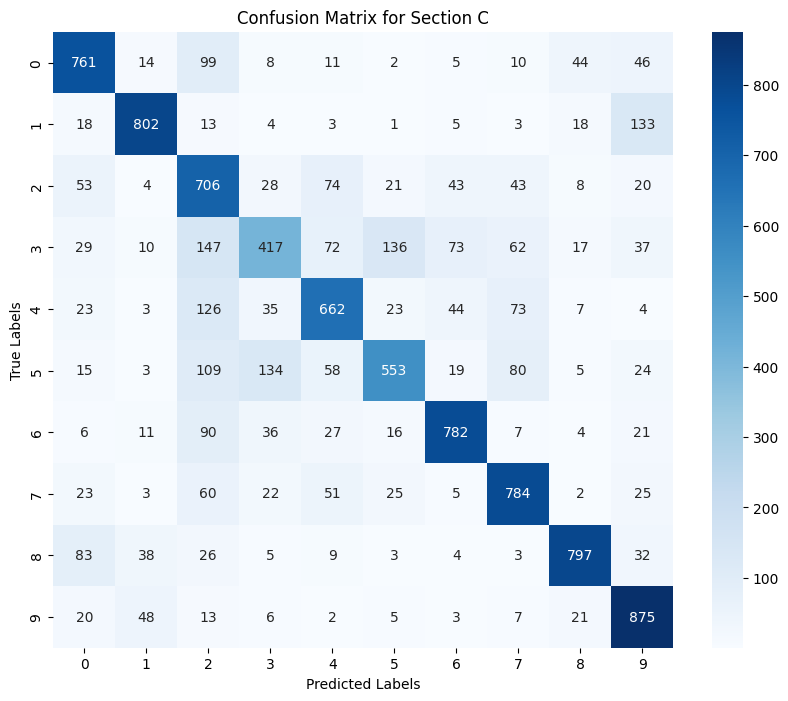

/tmp/ipykernel_23/2944194260.py:41: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(path)


Accuracy for Section D: 10.67%


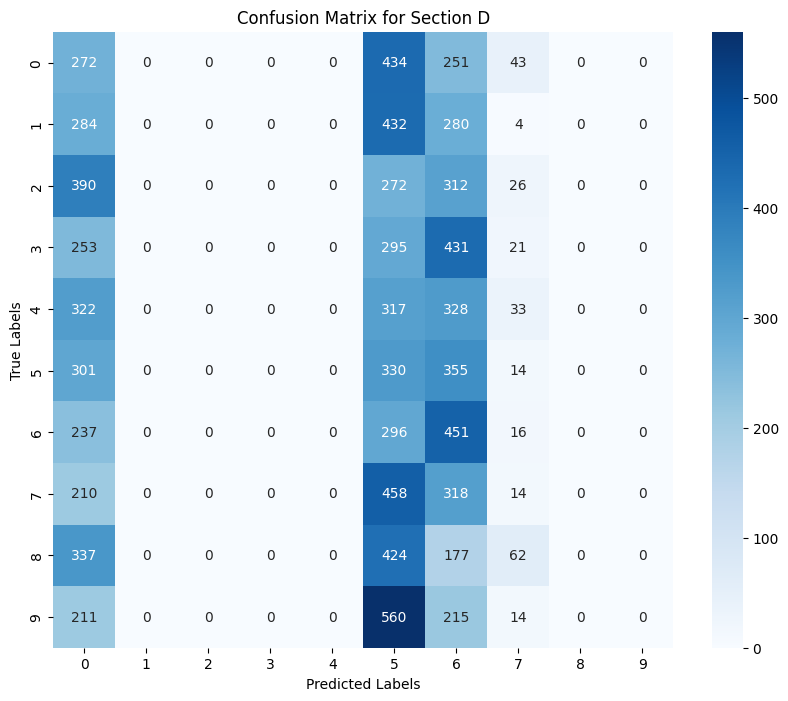

/tmp/ipykernel_23/2944194260.py:41: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(path)


Accuracy for Section E: 77.56%


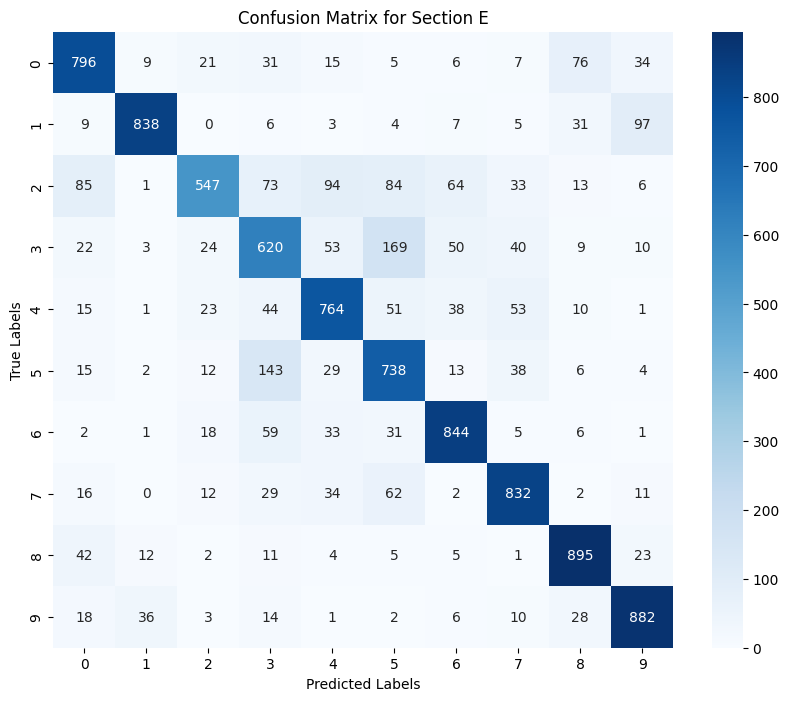

In [40]:
# Function to evaluate a model on the test set
def evaluate_model(model, test_loader, device):
    model.eval()
    y_true = []
    y_pred = []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())
    return y_true, y_pred

# Load saved models and evaluate on test set
model_paths = {
    "Section B": "best_baseline_model.pth",
    "Section C": "best_improved_model.pth",
    "Section D": "best_improved_model_with_bn.pth",
    "Section E": "best_improved_model_with_bn_and_do.pth"
}

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
test_accuracies = {}
confusion_matrices = {}

# Define your model architectures for each section
model_classes = {
    "Section B": BaselineModel,
    "Section C": ImprovedModel,
    "Section D": ImprovedModelWithBN,
    "Section E": ImprovedModelWithBNAndDO,
}

for section, path in model_paths.items():
    # Initialize the model
    model_class = model_classes[section]
    model = model_class().to(device)
    
    # Load the saved weights
    state_dict = torch.load(path)
    model.load_state_dict(state_dict)
    
    # Evaluate the model
    y_true, y_pred = evaluate_model(model, test_loader, device)
    
    # Calculate accuracy
    accuracy = accuracy_score(y_true, y_pred)
    test_accuracies[section] = accuracy
    
    # Generate confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    confusion_matrices[section] = cm

    # Report accuracy and plot confusion matrix
    print(f"Accuracy for {section}: {accuracy * 100:.2f}%")
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_true), yticklabels=np.unique(y_true))
    plt.title(f"Confusion Matrix for {section}")
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.show()
